<h1>At first we import packages we will need in the future (some of them will me imported further)</h1>

In [ ]:
import pandas as pd
import numpy as np
import ccxt
from datetime import datetime
import statsmodels.tsa.stattools
from sklearn.linear_model import LinearRegression
import statsmodels.api

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import argparse

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from sklearn.linear_model import LinearRegression

<h1>We dowload first half of the data (to avoid look-ahead bias) to do cointegration tests and ADF tests on their spreads</h1>

In [3]:
exchange = ccxt.binanceusdm()
pairs = exchange.load_markets()
quotes = pd.DataFrame()
columns = ['Timestamp', 'Open', 'High', 'Low', 'BTC/USDT', 'Volume']
ticker = pd.DataFrame(exchange.fetch_ohlcv("BTC/USDT", timeframe="4h"), columns=columns)

for pair in pairs:
    columns = ['Timestamp', 'Open', 'High', 'Low', pair, 'Volume']
    a = pd.DataFrame(exchange.fetch_ohlcv(pair, timeframe="4h"), columns=columns)
    print(str(round((list(pairs.keys()).index(pair)/len(list(pairs.keys()))*100), 2))+"%")
    if a.shape[0] == 500:
        quotes = pd.concat([quotes[:250], a[pair][:250]], axis=1)
print("Done!")
quotes = quotes.replace('/','_', regex=True)
quotes.to_csv("data/quotes_binance")

0.0%
0.83%
1.65%
2.48%
3.31%
4.13%
4.96%
5.79%
6.61%
7.44%
8.26%
9.09%
9.92%
10.74%
11.57%
12.4%
13.22%
14.05%
14.88%
15.7%
16.53%
17.36%
18.18%
19.01%
19.83%
20.66%
21.49%
22.31%
23.14%
23.97%
24.79%
25.62%
26.45%
27.27%
28.1%
28.93%
29.75%
30.58%
31.4%
32.23%
33.06%
33.88%
34.71%
35.54%
36.36%
37.19%
38.02%
38.84%
39.67%
40.5%
41.32%
42.15%
42.98%
43.8%
44.63%
45.45%
46.28%
47.11%
47.93%
48.76%
49.59%
50.41%
51.24%
52.07%
52.89%
53.72%
54.55%
55.37%
56.2%
57.02%
57.85%
58.68%
59.5%
60.33%
61.16%
61.98%
62.81%
63.64%
64.46%
65.29%
66.12%
66.94%
67.77%
68.6%
69.42%
70.25%
71.07%
71.9%
72.73%
73.55%
74.38%
75.21%
76.03%
76.86%
77.69%
78.51%
79.34%
80.17%
80.99%
81.82%
82.64%
83.47%
84.3%
85.12%
85.95%
86.78%
87.6%
88.43%
89.26%
90.08%
90.91%
91.74%
92.56%
93.39%
94.21%
95.04%
95.87%
96.69%
97.52%
98.35%
99.17%
Done!


<h1>Downloading second half of the data which we will use for backtests</h1>

In [6]:
exchange = ccxt.binanceusdm()
pairs = exchange.load_markets()
quotes = pd.DataFrame()
columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
path = "data/"

for pair in pairs:
    columns = ['Timestamp', 'Open', 'High', 'Low', "Close", 'Volume']
    a = pd.DataFrame(exchange.fetch_ohlcv(pair, timeframe="4h"), columns=columns)
    print(str(round((list(pairs.keys()).index(pair)/len(list(pairs.keys()))*100), 2))+"%")
    pair = pair.replace("/", "_")
    dt = list()
    for n in a.Timestamp:
        dt.append(datetime.fromtimestamp(n/1000))
    a.Timestamp = dt
    a[250:].to_csv(path+pair, index=False)
print("Done!")

0.0%
0.83%
1.65%
2.48%
3.31%
4.13%
4.96%
5.79%
6.61%
7.44%
8.26%
9.09%
9.92%
10.74%
11.57%
12.4%
13.22%
14.05%
14.88%
15.7%
16.53%
17.36%
18.18%
19.01%
19.83%
20.66%
21.49%
22.31%
23.14%
23.97%
24.79%
25.62%
26.45%
27.27%
28.1%
28.93%
29.75%
30.58%
31.4%
32.23%
33.06%
33.88%
34.71%
35.54%
36.36%
37.19%
38.02%
38.84%
39.67%
40.5%
41.32%
42.15%
42.98%
43.8%
44.63%
45.45%
46.28%
47.11%
47.93%
48.76%
49.59%
50.41%
51.24%
52.07%
52.89%
53.72%
54.55%
55.37%
56.2%
57.02%
57.85%
58.68%
59.5%
60.33%
61.16%
61.98%
62.81%
63.64%
64.46%
65.29%
66.12%
66.94%
67.77%
68.6%
69.42%
70.25%
71.07%
71.9%
72.73%
73.55%
74.38%
75.21%
76.03%
76.86%
77.69%
78.51%
79.34%
80.17%
80.99%
81.82%
82.64%
83.47%
84.3%
85.12%
85.95%
86.78%
87.6%
88.43%
89.26%
90.08%
90.91%
91.74%
92.56%
93.39%
94.21%
95.04%
95.87%
96.69%
97.52%
98.35%
99.17%
Done!


<h1>Calculating cointegration with ADF test on spreads with choosing 0.0001 p-value because we calculate whole universe of possible pairs</h1>
<h2>There are errors because I haven't yet implemented data cleaning process and some pairs incule delivery futures (not perpetual swaps) which have zeroes</h2>

In [12]:
df = pd.DataFrame(pd.read_csv("data/quotes_binance"))
df = df.drop(columns=["Unnamed: 0"])
len(df.columns)

def spread_adf(price1, price2):
    LR = LinearRegression()
    LR.fit(price1, price2)
    spread = LR.predict(price1)-price2
    return statsmodels.tsa.stattools.adfuller(spread)[1]

tickers = list(df.columns)

table_cointegration = pd.DataFrame(np.zeros((len(tickers), len(tickers))), columns = tickers, index = tickers)
table_adf = pd.DataFrame(np.zeros((len(tickers), len(tickers))), columns = tickers, index = tickers)

for ticker1 in tickers:
    print("%.2f done" % (list(tickers).index(ticker1)/len(tickers)*100))
    for ticker2 in tickers:
        if ticker1 == ticker2:
            table_cointegration.at[ticker1, ticker2] = 1
            table_adf.at[ticker1, ticker2] = 1
        else:
            table_cointegration.at[ticker1, ticker2] = statsmodels.tsa.stattools.coint(df[ticker1], df[ticker2])[1]
            table_adf.at[ticker1, ticker2] = spread_adf(df[[ticker1]], df[[ticker2]])

print("Done!")

coint_adf = pd.DataFrame(columns = ["Pair1", "Pair2", "Cointegration", "ADF"])

for ticker1 in table_adf.columns:
    for ticker2 in table_adf.columns:
        if table_cointegration[ticker1][ticker2] <= 0.0001:
            if table_adf[ticker1][ticker2] <= 0.0001:
                coint_adf = coint_adf.append({"Pair1": ticker1, "Pair2": ticker2, "Cointegration": table_cointegration[ticker1][ticker2], "ADF": table_adf[ticker1][ticker2]}, ignore_index=True)
coint_adf = coint_adf.replace('/','_', regex=True)
coint_adf.to_csv("CointegrationADF.csv", index=False)

0.00 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


0.89 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


1.79 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


2.68 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


3.57 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


4.46 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


5.36 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


6.25 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


7.14 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


8.04 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


8.93 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


9.82 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


10.71 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


11.61 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


12.50 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


13.39 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


14.29 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


15.18 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


16.07 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


16.96 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


17.86 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


18.75 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


19.64 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


20.54 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


21.43 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


22.32 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


23.21 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


24.11 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


25.00 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


25.89 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


26.79 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


27.68 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


28.57 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


29.46 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


30.36 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


31.25 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


32.14 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


33.04 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


33.93 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


34.82 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


35.71 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


36.61 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


37.50 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


38.39 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


39.29 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


40.18 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


41.07 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


41.96 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


42.86 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


43.75 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


44.64 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


45.54 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


46.43 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


47.32 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


48.21 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


49.11 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


50.00 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


50.89 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


51.79 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


52.68 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


53.57 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


54.46 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


55.36 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


56.25 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


57.14 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


58.04 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


58.93 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


59.82 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


60.71 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


61.61 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


62.50 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


63.39 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


64.29 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


65.18 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


66.07 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


66.96 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


67.86 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


68.75 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


69.64 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


70.54 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


71.43 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


72.32 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


73.21 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


74.11 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


75.00 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


75.89 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


76.79 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


77.68 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


78.57 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


79.46 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


80.36 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


81.25 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


82.14 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


83.04 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


83.93 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in

84.82 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


85.71 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


86.61 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


87.50 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


88.39 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


89.29 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


90.18 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


91.07 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


91.96 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


92.86 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


93.75 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


94.64 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


95.54 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


96.43 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


97.32 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


98.21 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


99.11 done


c:\python39\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Done!


<h1>We read file that contains pairs that have cointegration and ADF less or equal than our p-value and do a backtest on every single one of it, saving total return to the list</h1>

In [13]:
import datetime
pairs = pd.read_csv("CointegrationADF.csv", header=0)
returns = list()
zscore = list()
per = 70
stak = 1
divide = 2
open_threshold = 1.5
close_threshold = 0.3
cash = 200000
first_pair = "XMR_USDT"
second_pair = "BNB_USDT"
path = "data\\"



for id in range(len(pairs)):
    first_pair = pairs["Pair1"].iloc[id]
    second_pair = pairs["Pair2"].iloc[id]
    first_data = pd.read_csv(path + "quotes_binance")
    second_data = pd.read_csv(path + "quotes_binance")
    LR = LinearRegression()
    LR.fit(first_data[[first_pair]], second_data[[second_pair]])
    class PairTradingStrategy(bt.Strategy):
        params = dict(
            period=per,
            stake=stak,
            qty1=0,
            qty2=0,
            printout=True,
            upper=open_threshold,
            lower=-open_threshold,
            up_medium=close_threshold,
            low_medium=-close_threshold,
            status=0,
            portfolio_value=cash,
        )

        def log(self, txt, dt=None):
            if self.p.printout:
                dt = dt or self.data.datetime[-1]
                dt = bt.num2date(dt)
                #print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
                return  # Await further notifications

            if order.status == order.Completed:
                if order.isbuy():
                    buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                    self.log(buytxt, order.executed.dt)
                else:
                    selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                    self.log(selltxt, order.executed.dt)

            elif order.status in [order.Expired, order.Canceled, order.Margin]:
                self.log('%s ,' % order.Status[order.status])
                pass  # Simply log

            # Allow new orders
            self.orderid = None

        def notify_trade(self, trade):
            if not trade.isclosed:
                return

            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                     (trade.pnl, trade.pnlcomm))

        def __init__(self):
            # To control operation entries
            self.orderid = None
            self.qty1 = self.p.qty1
            self.qty2 = self.p.qty2
            self.upper_limit = self.p.upper
            self.lower_limit = self.p.lower
            self.up_medium = self.p.up_medium
            self.low_medium = self.p.low_medium
            self.status = self.p.status
            self.portfolio_value = self.p.portfolio_value

            # Signals performed with PD.OLS :
            self.transform = btind.OLS_TransformationN(self.data0, self.data1,
                                                       period=self.p.period)
            self.zscore = self.transform.zscore
            self.stake = stak
            # Checking signals built with StatsModel.API :
            # self.ols_transform = btind.OLS_Transformation(self.data0, self.data1,
            #                                              period=self.p.period,
            #                                              plot=True)

        def next(self):

            if self.orderid:
                return  # if an order is active, no new orders are allowed

            if self.p.printout:
                #print('Self  len:', len(self))
                #print('Data0 len:', len(self.data0))
                #print('Data1 len:', len(self.data1))
                #print('Data0 len == Data1 len:',
                #      len(self.data0) == len(self.data1))
                zscore.append(self.zscore[0])
                # spread.append(self.spread)

                #print('Data0 dt:', self.data0.datetime.datetime())
                #print('Data1 dt:', self.data1.datetime.datetime())
                #print('Portfolio value:', self.broker.getvalue())
            #print('status is', self.status)
            #print('zscore is', self.zscore[0])

            # Step 2: Check conditions for SHORT & place the order
            # Checking the condition for SHORT
            if (self.zscore[0] >= self.upper_limit) and (self.status != 1):

                # Calculating the number of shares for each stock
                value = (self.stake / divide) * self.portfolio_value  # Divide the cash equally
                if LR.coef_[0][0] > 1:
                    y = value / (self.data1.close)
                    x = y / LR.coef_[0][0]
                elif LR.coef_[0][0] < 1:
                    x = value / (self.data0.close)  # Find the number of shares for Stock1
                    y = x * LR.coef_[0][0]  # Find the number of shares for Stock2
                #print('x + self.qty1 is', x + self.qty1)
                #print('y + self.qty2 is', y + self.qty2)

                # Placing the order
                #self.log('SELL CREATE %s, price = %.2f, qty = %d' % (first_pair, self.data0.close[0], x + self.qty1))
                self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
                #self.log('BUY CREATE %s, price = %.2f, qty = %d' % (second_pair, self.data1.close[0], y + self.qty2))
                self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

                # Updating the counters with new value
                self.qty1 = x  # The new open position quantity for Stock1 is x shares
                self.qty2 = y  # The new open position quantity for Stock2 is y shares

                self.status = 1  # The current status is "short the spread"

                # Step 3: Check conditions for LONG & place the order
                # Checking the condition for LONG

            elif (self.zscore[0] <= self.lower_limit) and (self.status != 2):

                # Calculating the number of shares for each stock
                value = (self.stake / divide) * self.portfolio_value  # Divide the cash equally
                x = value / (self.data0.close)  # Find the number of shares for Stock1
                y = value / (self.data1.close)  # Find the number of shares for Stock2
                #print('x + self.qty1 is', x + self.qty1)
                #print('y + self.qty2 is', y + self.qty2)

                # Place the order

                #self.log('SELL CREATE %s, price = %.2f, qty = %d' % (second_pair, self.data1.close[0], y + self.qty2))
                self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares
                #self.log('BUY CREATE %s, price = %.2f, qty = %d' % (first_pair, self.data0.close[0], x + self.qty1))
                self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares

                # Updating the counters with new value
                self.qty1 = x  # The new open position quantity for Stock1 is x shares
                self.qty2 = y  # The new open position quantity for Stock2 is y shares
                self.status = 2  # The current status is "long the spread"

                # Step 4: Check conditions for No Trade
                # If the z-score is within the two bounds, close all

            elif (self.status == 2 or self.status == 1) and (
                    self.zscore[0] < self.up_medium and self.zscore[0] > self.low_medium):
                #self.log('CLOSE LONG %s, price = %.2f' % ("ABN", self.data0.close[0]))
                self.close(self.data0)
                #self.log('CLOSE LONG %s, price = %.2f' % ("ING", self.data1.close[0]))
                self.close(self.data1)
                self.status = 0

        def stop(self):
            print('==================================================')
            print('Starting Value - %.2f' % self.broker.startingcash)
            print('Ending   Value - %.2f' % self.broker.getvalue())
            returns.append([first_pair, second_pair, self.broker.getvalue() / self.broker.startingcash])
            print('==================================================')


    def runstrategy():
        args = parse_args()

        # Create a cerebro
        cerebro = bt.Cerebro()
        # Get the dates from the args
        fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d %H:%M:%S')
        todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d %H:%M:%S')

        # Create the 1st data
        class Tickstory(btfeeds.GenericCSVData):
            params = (
                ('dtformat', '%Y-%m-%d %H:%M:%S'),
                ('datetime', 0),
                ('time', -1),
                ('open', 1),
                ('high', 2),
                ('low', 3),
                ('close', 4),
                ('volume', -1),
                ('openinterest', -1),
                ('timeframe', bt.TimeFrame.Minutes),
                ('compression', 1)
            )

        # Develop feed
        data0 = Tickstory(dataname="data/" + first_pair)

        # Add the 1st data to cerebro
        cerebro.adddata(data0)
        # Develop feed
        data1 = Tickstory(dataname="data/" + second_pair)
        # Add the 2nd data to cerebro
        cerebro.adddata(data1)
        # Add the strategy
        cerebro.addstrategy(PairTradingStrategy,
                            period=args.period,
                            stake=args.stake)

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcash(args.cash)

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcommission(commission=args.commperc)

        # And run it
        cerebro.run(runonce=not args.runnext,
                    preload=not args.nopreload,
                    oldsync=args.oldsync)

        # Plot if requested
        #cerebro.plot(iplot=False, volume=False)


    def parse_args():
        parser = argparse.ArgumentParser(description='MultiData Strategy')

        parser.add_argument('--data0', '-d0',
                            default=first_pair,
                            help='1st data into the system')

        parser.add_argument('--data1', '-d1',
                            default=second_pair,
                            help='2nd data into the system')

        parser.add_argument('--fromdate', required=False,
                            default='2017-07-04  09:00:00',
                            help='Starting date in YYYY-MM-DD format')

        parser.add_argument('--todate', required=False,
                            default='2021-07-15  11:00:00',
                            help='Ending date in YYYY-MM-DD format')

        parser.add_argument('--period', default=per, type=int,
                            help='Period to apply to the Simple Moving Average')

        parser.add_argument('--cash', default=cash, type=int,
                            help='Starting Cash')

        parser.add_argument('--runnext', action='store_true',
                            help='Use next by next instead of runonce')

        parser.add_argument('--nopreload', action='store_true',
                            help='Do not preload the data')

        parser.add_argument('--oldsync', action='store_true',
                            help='Use old data synchronization method')

        parser.add_argument('--commperc', default=0.0014, type=float,
                            help='Percentage commission (0.005 is 0.5%%')

        parser.add_argument('--stake', default=stak, type=int,
                            help='Stake to apply in each operation')

        parser.add_argument('--plot', '-p', default=True, action='store_true',
                            help='Plot the read data')

        parser.add_argument('--numfigs', '-n', default=1,
                            help='Plot using numfigs figures')
        parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

        return parser.parse_args()


    if __name__ == '__main__':
        runstrategy()

returns = pd.DataFrame(returns)
returns.to_csv("Returns.csv")

Starting Value - 200000.00
Ending   Value - 195626.16
Starting Value - 200000.00
Ending   Value - 215961.27
Starting Value - 200000.00
Ending   Value - 195107.83
Starting Value - 200000.00
Ending   Value - 171007.35
Starting Value - 200000.00
Ending   Value - 149308.52
Starting Value - 200000.00
Ending   Value - 182264.60
Starting Value - 200000.00
Ending   Value - 252106.06
Starting Value - 200000.00
Ending   Value - 198911.28
Starting Value - 200000.00
Ending   Value - 153185.01
Starting Value - 200000.00
Ending   Value - 240444.57
Starting Value - 200000.00
Ending   Value - 210741.13
Starting Value - 200000.00
Ending   Value - 191173.37
Starting Value - 200000.00
Ending   Value - 256245.77
Starting Value - 200000.00
Ending   Value - 207536.25
Starting Value - 200000.00
Ending   Value - 191051.29
Starting Value - 200000.00
Ending   Value - 199909.61
Starting Value - 200000.00
Ending   Value - 165596.09
Starting Value - 200000.00
Ending   Value - 227042.98
Starting Value - 200000.00
E

<h1>In the end we analyze the returns to see if all the pairs in total were at least profitable</h1>

(array([ 1.,  4.,  3.,  4.,  8., 10., 10.,  6.,  3.,  2.]),
 array([0.64106718, 0.71274951, 0.78443185, 0.85611418, 0.92779651,
        0.99947884, 1.07116117, 1.1428435 , 1.21452583, 1.28620816,
        1.35789049]),
 <a list of 10 Patch objects>)

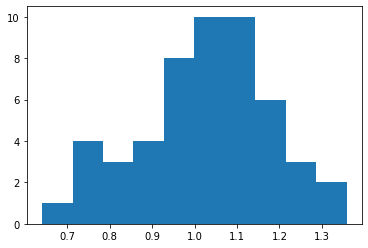

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("Returns.csv", names = ["Pair1", "Pair2", "Return"])
df = df.sort_values(by=["Return"], ignore_index=True)
df = df.head(-1) # We delete last row because it was automatically created by Python
plt.hist(df.Return)

<h1>We can see that we have almost a normal distrubution with negative skewness and kurtosis, lets check yield % for the tested period (1 month)</h1>

In [29]:
cash = 100
portfolio_value = cash*len(df)
end_value = (df.Return*cash).sum()
yield1 = end_value/portfolio_value - 1
print("Yield for the period is: %.3f" % (yield1*100) + "%")

Yield for the period is: 2.741%


<h1>There is a lot of work to do like:</h1>

<h3>Integrate rolling cointegration</h3>

<h3>Integrate recalculation of hedge ratio</h3>

<h3>Implement drawdown and calculation of characteristics like Sharpe ratio</h3>

<h3>Do a hyperparameter optimization to define best parameters for a strategy based on data, etc.</h3>

<h1>But this is a pet project to get experience of creating and testing strategies</h1>